In [1]:
# Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from math import ceil
import datetime
import matplotlib.font_manager as fm
import matplotlib as mpl


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

plt.rcParams['font.family'] = 'Malgun Gothic'
rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 12.0, 'axes.titlesize': 20}
plt.rcParams.update(**rc)
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
os.getcwd()

'D:\\kaggle\\predict_future_sales\\competitive-data-science-predict-future-sales'

### Data Description
#### You are provided with daily historical sales data.
#### The task is to forecast the total amount of products sold in every shop for the test set. 
#### Note that the list of shops and products slightly changes every month. 
#### Creating a robust model that can handle such situations is part of the challenge.

#### File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.


#### Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### 진행 방향 

#### 1. 데이터 정상성 확인 (시각화 및 Dicky-fuller P-val)
#### 2. 비정상일시 정상화 진행 (상황에 맞게 변환 또는 차분)
#### 3. 예측 모델 설정 및 적용 (AR/MA/ARIMA)

### Load data

In [2]:
%%time
train=pd.read_csv("sales_train.csv",encoding='utf-8')
test=pd.read_csv("test.csv",encoding='utf-8')
items=pd.read_csv("items.csv",encoding='utf-8')
item_categories=pd.read_csv("item_categories.csv",encoding='utf-8')
shops=pd.read_csv("shops.csv",encoding='utf-8')

Wall time: 1.76 s


In [3]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0


In [4]:
test.head(1)

,ID,shop_id,item_id
0,0,5,5037


In [5]:
items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


In [6]:
item_categories.head(1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


In [7]:
shops.head(1)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


### test의 id 들이 train에 다 포함되는지 확인 - test의 item_id 중 363개는 train에 없음?!

In [8]:
train_shop_id=set(train.shop_id.unique())
train_item_id=set(train.item_id.unique())

test_shop_id=set(test.shop_id.unique())
test_item_id=set(test.item_id.unique())

#각 개수
print("################ shop_id ################")
print("train_shop_id : {}".format(len(train_shop_id)))
print("test_shop_id : {}".format(len(test_shop_id)))
print("train ∩ test : {}".format(len(train_shop_id & test_shop_id)))
print("#########################################")
print()
print("################ item_id ################")
print("train_item_id : {}".format(len(train_item_id)))
print("test_item_id : {}".format(len(test_item_id)))
print("train ∩ test : {}".format(len(train_item_id & test_item_id)))
print("test only {}".format(len(test_item_id)-len(train_item_id & test_item_id)))
print("#########################################")
test_only=test[~test['item_id'].isin(train['item_id'].unique())]['item_id'].unique()

################ shop_id ################
train_shop_id : 60
test_shop_id : 42
train ∩ test : 42
#########################################

################ item_id ################
train_item_id : 21807
test_item_id : 5100
train ∩ test : 4737
test only 363
#########################################


### 중복 열 확인 및 중복열 하나만 남기고 나머지 제거

In [10]:
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=subset).value_counts())

False    2935825
True          24
dtype: int64


In [11]:
train.drop_duplicates(subset=subset, inplace=True)

In [12]:
print(train.duplicated(subset=subset).value_counts())

False    2935825
dtype: int64


### item_category_id 추가

In [13]:
train=pd.merge(train,items,how="left",on='item_id').drop(columns='item_name')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


### date 열 datetime형으로 변경 

In [14]:
train['date']=pd.to_datetime(train['date'])
train['date'][0:3]

0   2013-02-01
1   2013-03-01
2   2013-05-01
Name: date, dtype: datetime64[ns]

### NA 확인 - 모든 열이 NOT NULL 임을 확인

In [15]:
train.isna().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

In [16]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935825e+06,2.935825e+06,2.935825e+06,2.935825e+06,2.935825e+06,2.935825e+06
mean,1.456992e+01,3.300171e+01,1.019721e+04,8.908558e+02,1.242643e+00,4.000137e+01
std,9.422984e+00,1.622699e+01,6.324298e+03,1.729806e+03,2.618845e+00,1.710079e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935825 entries, 0 to 2935824
Data columns (total 7 columns):
date                datetime64[ns]
date_block_num      int64
shop_id             int64
item_id             int64
item_price          float64
item_cnt_day        float64
item_category_id    int64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 179.2 MB


In [18]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-02-01,0,59,22154,999.0,1.0,37


### date_block_num : 월 구분 열에 따라 월 (shop_id,item_id별 데이터 확인)

In [19]:
monthly=pd.DataFrame(
        train.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day']. #그룹핑 및 열 선택
        agg({'date':['min','max'],
             'item_price':['mean'],
             'item_cnt_day':['sum']})).reset_index()
monthly[:10]

date_block_num shop_id item_id       date            item_price item_cnt_day
                                        min        max       mean          sum
0              0       0      32 2013-01-21 2013-03-01      221.0          6.0
1              0       0      33 2013-01-17 2013-03-01      347.0          3.0
2              0       0      35 2013-01-31 2013-01-31      247.0          1.0
3              0       0      43 2013-01-31 2013-01-31      221.0          1.0
4              0       0      51 2013-01-13 2013-01-31      128.5          2.0
5              0       0      61 2013-10-01 2013-10-01      195.0          1.0
6              0       0      75 2013-01-17 2013-01-17       76.0          1.0
7              0       0      88 2013-01-16 2013-01-16       76.0          1.0
8              0       0      95 2013-06-01 2013-06-01      193.0          1.0
9              0       0      96 2013-10-01 2013-10-01       70.0          1.0

### 월 간격별 총 아이템 판매량 추이 확인

In [22]:
ts=train.groupby('date_block_num')['item_cnt_day'].sum().reset_index() #timeseires
ts.astype('float')
ts.head(3)

,date_block_num,item_cnt_day
0,0,131476.0
1,1,128088.0
2,2,147140.0


## 1. 데이터 정상성 확인

### 1) 시각화로 확인
- 아이템 판매량이 12개월(약 1년) 주기로 트랜드(추세요인)를 가짐, 차후 정상화 과정(변환 또는 차분)이 필요할 것으로 판단됨

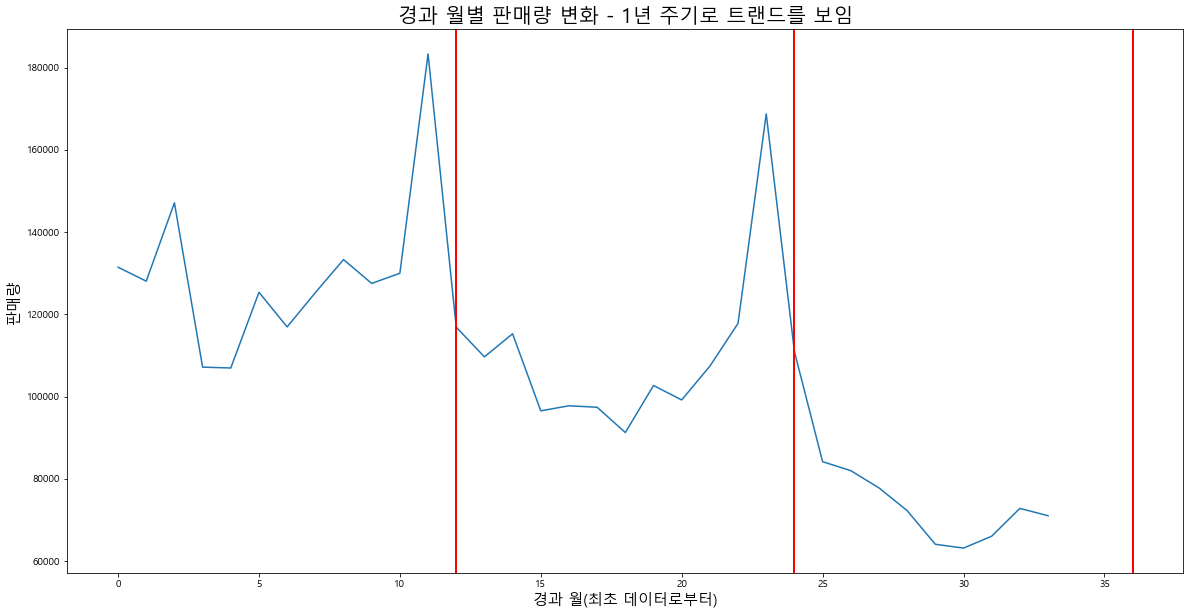

In [23]:
plt.figure(figsize=(20,10))
plt.title('경과 월별 판매량 변화 - 1년 주기로 트랜드를 보임')
ax=sns.lineplot(
            data=ts,
            x='date_block_num',
            y='item_cnt_day')
ax.set(xlabel='경과 월(최초 데이터로부터)', ylabel='판매량')
plt.axvline(x=12, c='r', linewidth=2)
plt.axvline(x=24, c='r', linewidth=2)
plt.axvline(x=36, c='r', linewidth=2)
plt.show()

### 2) Dicky Fuller Test를 통한 정상성 확인(신뢰수준 95% 기준,기각역 5%로 판단)
- Critical Value (5%) 기준(기준통계량 -2.954127)
- 검정통계량 -2.395704, p-val 0.14로 비정상 시계열로 판단됨
- 변환 또는 차분을 하여 정상시계열로 만들 필요가 있음을 확인함

In [24]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts.item_cnt_day)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395640
p-value                         0.142971
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


### 분해 시계열 : 시계열에 영향을 주는 요소들을 분해하여 확인하는 것
- 추세+순환요인(Trend) / 계절요인(seasonal) / 불규칙요인(residual, 잔차(오차))

<Figure size 1440x1080 with 0 Axes>

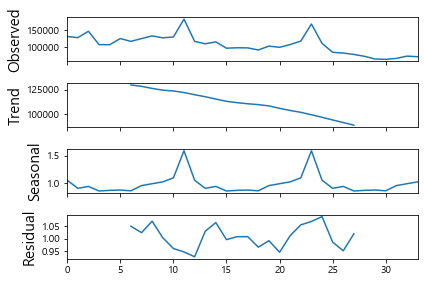

In [25]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.item_cnt_day,freq=12,model="multiplicative")
plt.figure(figsize=(20,15))
fig = res.plot()
#fig.show()

<Figure size 1440x1080 with 0 Axes>

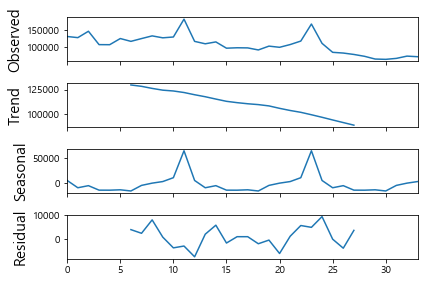

In [26]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.item_cnt_day,freq=12,model="additive")
plt.figure(figsize=(20,15))
fig = res.plot()
#fig.show()

In [20]:
plt.figure(figsize=(20,20))
sns.lineplot(data=grouped_item_cnt,
            x='date_block_num',
            y='item_cnt_day',
            hue='shop_id',
            palette='Set1')

NameError: name 'grouped_item_cnt' is not defined

<Figure size 1440x1440 with 0 Axes>

In [ ]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

In [ ]:
#f, axes = plt.subplots(1, 2, figsize = (20, 10))

#sns.countplot(train['shop_id'],   ax=axes[0])
#sns.countplot(sales_train['item_category_id'],   ax=axes[1])

#df_train['Survived'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', ax = ax[0], shadow = True)
# explode : pie 그래프의 간격 조정
# autopct : pie 그래프 내 표시될 글자 형태

In [ ]:
monthly=pd.DataFrame(
        train.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].\
        agg({'date':['min','max'],
             'item_price':['mean'],
             'item_cnt_day':['sum']}))
monthly[:10]

In [ ]:
train.head()